In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import numpy as np

In [3]:
df = pd.read_csv("mushrooms.csv")
print("dataset shape:", df.shape)

dataset shape: (8124, 23)


# data preprocessing

In [4]:
# check duplicates 
duplicates = df.duplicated().sum()
if duplicates > 0: 
    df.drop_duplicates(inplace=True)

In [5]:
# check missing values 
missing = {}
for col in df.columns: 
    if '?' in df[col].unique(): 
        count = df[col].value_counts()['?']
        missing[col] = count 

print(f"missing data: {missing}")

missing data: {'stalk-root': np.int64(2480)}


In [6]:
# check zero variance columns 
drop_cols = []
for col in df.columns: 
    if df[col].nunique() == 1: 
        drop_cols.append(col)

if drop_cols: 
    print(f"dropping zero variance columns (homogen or zero entropy): {drop_cols}")

dropping zero variance columns (homogen or zero entropy): ['veil-type']


C:\Users\HP\AppData\Local\Temp\ipykernel_25388\496750998.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="class", data=df, palette="viridis")


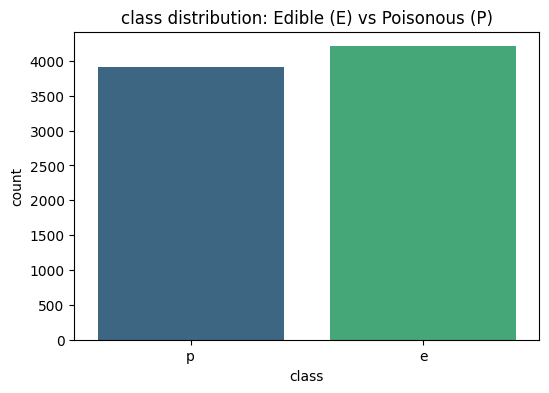

In [8]:
# visualize class balance 
plt.figure(figsize=(6, 4))
sns.countplot(x="class", data=df, palette="viridis") 
plt.title("class distribution: Edible (E) vs Poisonous (P)")
plt.show()

In [9]:
# split data 
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
split_idx = int(0.8 * len(df))
train_df = df.iloc[:split_idx]
test_df = df.iloc[split_idx:]

print(f"training data: {train_df.shape}")
print(f"test data: {test_df.shape}")

training data: (6499, 23)
test data: (1625, 23)


# naive bayes model

In [14]:
class NaiveBayesClassifier: 
    def __init__(self): 
        self.priors = {}
        self.likelihoods = {}
        self.classes = []
        self.features = []
    
    def fit(self, X, y): 
        self.classes = np.unique(y)
        self.features = X.columns
        n_rows = len(y) 

        for c in self.classes: 
            self.priors[c] = np.log(len(y[y == c]) / n_rows) 

            self.likelihoods = {feat: {} for feat in self.features}

            for feat in self.features: 
                unique_vals = X[feat].unique()
                n_unique = len(unique_vals) 

                for c in self.classes: 
                    self.likelihoods[feat][c] = {}
                    subset_c = X[y == c] 
                    count_c = len(subset_c) 

                    for val in unique_vals: 
                        count_val = len(subset_c[subset_c[feat] == val]) 

                        prob = (count_val + 1) / (count_c + n_unique) 

                        self.likelihoods[feat][c][val] = np.log(prob) 

                    self.likelihoods[feat][c]["__unseen__"] = np.log(1 / (count_c + n_unique))

    def predict(self, X): 
        predictions = [] 

        for _, row in X.iterrows(): 
            posteriors = {} 

            for c in self.classes: 
                posterior = self.priors[c] 

                for feat in self.features: 
                    val = row[feat] 

                    if val in self.likelihoods[feat][c]: 
                        posterior += self.likelihoods[feat][c][val]
                    else: 
                        posterior += self.likelihoods[feat][c]["__unseen__"]
                    
                posteriors[c] = posterior
            
            best_class = max(posteriors, key=posteriors.get) 
            predictions.append(best_class) 

        return predictions

# evals

In [15]:
X_train = train_df.drop('class', axis=1)
y_train = train_df['class']
X_test = test_df.drop('class', axis=1)
y_test = test_df['class']

In [16]:
model = NaiveBayesClassifier()
model.fit(X_train, y_train)

In [17]:
preds = model.predict(X_test)

In [19]:
correct = sum(1 for p, t in zip(preds, y_test) if p == t)
accuracy = correct / len(y_test)

print(f"Model Accuracy: {accuracy * 100:.2f}%")

Model Accuracy: 95.26%
